In [1]:
from langgraph.graph import StateGraph, START, END
from typing import Literal, TypedDict
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import os
load_dotenv()

True

In [23]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI(
    model="gpt-4o",
    temperature=0.2,
    top_p=0.1,
    max_tokens=1200,
    api_key=OPENAI_API_KEY
)

In [3]:
from typing import Optional, Union

class IntentAgentResponse(BaseModel):
    intent: Literal["reading_comprehension", "verbal_ability", "critical_reasoning", "exam_mind_simulator", "option_elimination", "preparation_strategy", "general_help", "mock_test"]
    difficulty_level: Literal["easy", "medium", "hard"]
    rc_question_type: Optional[Literal["tone", "main_idea", "summary", "conclusion", "detail", "application", "author_purpose", "structure"]] = None


class ToneResponse(BaseModel):

    tone_of_passage: Literal[
        "Formal", "Informal", "Optimistic", "Pessimistic", "Serious",
        "Humorous", "Sarcastic", "Critical", "Sympathetic", "Objective",
        "Subjective", "Encouraging", "Cautious", "Joyful", "Melancholic",
        "Detached", "Enthusiastic", "Ironic", "Neutral", "Admiring",
        "Indifferent", "Cynical", "Reflective", "Nostalgic", "Regretful",
        "Didactic", "Authoritative", "Defensive", "Skeptical", "Witty"
    ]
    explanation: str = Field(..., description="A brief explanation of why this tone was chosen based on the passage content.")

class CATAgentState(TypedDict, total = False):

    passage: str
    user_query: str
    intent_metadata: IntentAgentResponse  # Structured data

    rc_response: Union[str, ToneResponse]  # reading comprehension agent answer
    option_elimination_response: str  # option elimination agent answer
    exam_mind_simulator_response: str  # exam mind simulator agent answer
    general_agent_response: str  # general agent answer
    final_answer: str  # Synthesizer agent answer



In [4]:
# class ReadingComprehensionAgent(BaseModel):

#     passage: str = Field(..., description="The passage to answer the question given by intent agent", min_length=3)
#     user_query: str = Field(..., description="The user query to the question given by intent agent", min_length=3)
#     # intent_metdata: IntentAgentResponse
#     output: Optional[str] = Field(None, description="The output of the reading comprehension agent", min_length=3)

In [5]:

# intent agent node
def classify_intent_node(state: CATAgentState):
    # prompts 
    intent_classifier_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """You are an expert CAT VARC intent classifier. 
            Analyze the student's query and classify it into one of these categories:
            - reading_comprehension: Questions about RC passages, strategies, comprehension
            - verbal_ability: Grammar, vocabulary, sentence correction, para jumbles
            - critical_reasoning: Logical reasoning, assumptions, conclusions, arguments, inference
            - exam_mind_simulator: Simulating examiner's mind, question design, psychological traps
            - option_elimination: Strategies for eliminating options, decision-making, confusing options
            - preparation_strategy: Study plans, time management, resources
            - general_help: Study plans, motivation, general CAT advice
            - mock_test: Practice tests, mock exams, timed practice
         
            IF the intent is "reading_comprehension", also identify the specific RC question type:
            - tone: Questions about author's attitude, mood, feeling, tone
            - main_idea: Questions about central theme, primary purpose, main point
            - summary: Questions asking to summarize or provide overview
            - conclusion: Questions about what the passage concludes
            - detail: Questions about specific information mentioned in passage
            - application: Questions about applying passage ideas to new scenarios
            - author_purpose: Questions about why the author wrote this
            - structure: Questions about how the passage is organized
            from the {passage} provided, extract the intent category.
            Also extract:
            - current_topic: Specific topic within the category
            - difficulty_level: 1 (beginner) to 5 (expert)
            """),
        ("human", "{user_query}"),
    ]
)
    messages = intent_classifier_prompt.format_messages(
        passage = state['passage'],
        user_query = state['user_query']
    )
    structured_model = model.with_structured_output(IntentAgentResponse)
    response = structured_model.invoke(messages)
    # Return dict with the key to update in state
    print(f"📋 Classified Intent: {response.intent} (RC Type: {response.rc_question_type})  (difficulty: {response.difficulty_level})")
    # return {"intent_metadata": response}
    return {"intent_metadata": response}

In [6]:
# reading comprehension agent

def reading_comprehension_agent_node(state: CATAgentState):
    # prompts
    print(" running the reading comprehnesion agent")
    intent_data = state['intent_metadata']
    print(intent_data)
    if intent_data.rc_question_type == "tone":
        tone_prompt_template = ChatPromptTemplate.from_messages ([
            ("system", """You are an expert at analyzing passage tone.
            Analyze the tone of the following passage and:
            1. Classify it using ONE of these specific categories
            2. Explain WHY you chose this tone with evidence from the passage
            passage {passage}
          """),
          ("human", "{query}")
        ])
        messages = tone_prompt_template.format_messages(
            passage=state['passage'],
            query=state['user_query']
        )
        structured_model = model.with_structured_output(ToneResponse)
        response = structured_model.invoke(messages)
        return {"rc_response": response}

    else:
        reading_comprehension_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert CAT Reading Comprehension tutor with 15+ years of experience.
                
                Your capabilities:
                1. Analyze RC passages and identify key themes, structure, and tone, main idea, conclusion, and author's intent, summary
                2. Explain different question types (main idea, inference, detail, etc.)
                3. Provide time-saving reading strategies
                4. Generate practice questions with detailed explanations
                5. Identify student's weakness patterns
                Provide comprehensive, actionable advice with specific examples.
                Always end with a personalized next step recommendation.
                Question type: {rc_question_type}
                difficulty: {difficulty}
                Passage to analyze: {passage}
                
                """),
                ("human", "{query}")
            ])
        messages = reading_comprehension_prompt.format_messages(
            
            passage=state['passage'],
            query=state['user_query'],
            rc_question_type=intent_data.rc_question_type,
            difficulty=intent_data.difficulty_level

        )
        response = model.invoke(messages).content
        return {"rc_response": response}

# Intent metadata: {intent_metadata}


In [7]:
# option elimination agent

def option_elimination_agent_node(state: CATAgentState):
    # prompts
    print(" running the option elimination agent")
    option_elimination_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the world's leading expert in logical reasoning for CAT VARC section.

    Provide SYSTEMATIC LOGICAL ELIMINATION:

    1. **For each option, analyze:**
    - Logical relationship to passage content
    - Scope accuracy (too broad/narrow/just right)
    - Factual accuracy vs. passage statements
    - Logical consistency with question requirements

    2. **Elimination order (easiest to eliminate first):**
    - Which options can be eliminated immediately and why
    - Which require deeper analysis
    - Logical elimination sequence

    3. **Final logical conclusion:**
    - Which option survives logical scrutiny
    - Degree of logical certainty (1-10)
    - Potential logical ambiguities

    Use rigorous logical analysis worthy of a philosophy PhD.
    Analyze from PSYCHOLOGICAL PERSPECTIVE:

    1. **For each option, identify:**
    - What psychological appeal it has
    - What type of student mindset it targets
    - What cognitive biases it exploits
    - Why students might find it attractive

    2. **Student vulnerability analysis:**
    - Which options this student profile is most likely to choose
    - What psychological traps they might fall into
    - How their weak areas make them vulnerable

    3. **Psychological elimination strategy:**
    - How to recognize and avoid psychological traps
    - Mental frameworks to maintain objectivity
    - Confidence-building techniques during elimination
     
    EXAMINER PSYCHOLOGY ANALYSIS:

    1. **Examiner's design intent:**
    - What skill is this question really testing?
    - How examiner wants students to think
    - What separates 99%ile from 90%ile students

    2. **Distractor design psychology:**
    - Which options are "honey traps" for different skill levels
    - How examiner made wrong options attractive
    - What student mistakes each wrong option represents

    3. **Examiner elimination shortcuts:**
    - Secret patterns examiners use consistently
    - How to think like examiner during elimination
    - Examiner's "golden rules" for answer selection

    4. **Quality assurance insights:**
    - How examiner validated the correct answer
    - What makes an option "examiner-approved"
    - How to spot examiner's intended correct answer

    Reveal the secrets that only CAT question creators know.
    
    Provide comprehensive, actionable advice with specific examples.
    Always end with a personalized next step recommendation. {passage}"""),
    ("human", "{query}")
    ])
    messages = option_elimination_prompt.format_messages(
        passage=state['passage'],
        query=state['user_query']
    )
    response = model.invoke(messages).content
    return {"option_elimination_response": response}

In [8]:
# exam_mind_simulattor_agent
def exam_mind_simulator_agent_node(state: CATAgentState):
    # prompts
    print(" running the exam mind simulator agent")
    exam_mind_simulator_prompt = ChatPromptTemplate.from_messages([
    ("system", """ You are CAT leading examiner with 20+ years of experience in designing complex logical reasoning questions for the CAT VARC section.
    "name": "Dr. Amit Verma",
                "experience": "12+ years IIM faculty + CAT design",
                "specialty": "Strategic thinking and business contexts",
                "psychology": "Tests practical application",
                "trap_style": "Real-world scenario complications",
                "difficulty_preference": "Variable based on relevance"
    
    "name": "Prof. Meera Patel", 
                "experience": "20+ years English literature + CAT",
                "specialty": "Vocabulary and reading comprehension",
                "psychology": "Tests language precision",
                "trap_style": "Vocabulary confusion and context traps",
                "difficulty_preference": "Consistent high standards"
    "name": "Dr. Rajesh Sharma",
                "experience": "15+ years CAT examination",
                "specialty": "Logical reasoning and inference questions",
                "psychology": "Tests deep analytical thinking",
                "trap_style": "Subtle logical fallacies",
                "difficulty_preference": "Progressive complexity"
     
    You just created this question. Reveal your exact thinking process:
     
    Provide comprehensive, actionable advice with specific examples.
     As the examiner, explain step-by-step:

    1. **Why I chose this specific passage section**
    - What made this part "question-worthy"
    - What skill I wanted to test
    - How I ensured appropriate difficulty

    2. **My question design philosophy**
    - What cognitive process I want students to demonstrate
    - How this fits into overall CAT assessment strategy
    - What separates good students from average ones here

    3. **My expectations for student responses**
    - What I expect 90th percentile students to do
    - What I expect 60th percentile students to do
    - Common mistakes I anticipate

    4. **My quality assurance process**
    - How I validated this question
    - What I checked to ensure fairness
    - How I balanced difficulty vs. discrimination
    As the examiner, reveal your distractor design strategy:

    1. **For each wrong option, explain:**
    - What psychological trap I embedded
    - What type of student thinking leads to this choice
    - How I made it "attractive but wrong"
    - What knowledge gap this reveals

    2. **My overall distractor strategy:**
    - How I ensured one clearly correct answer
    - How I balanced plausibility across options
    - What I did to prevent multiple correct interpretations

    3. **Psychological manipulation techniques:**
    - How I used common student misconceptions
    - What shortcuts I expect students to take
    - How I tested thorough vs. superficial reading
    A trusted colleague asks you to privately share the "insider secrets" that you would never tell students publicly. Share:

    1. **The 80/20 secrets of CAT question design:**
    - What 20% of skills determine 80% of success
    - What we actually look for vs. what students think we look for
    - The hidden patterns in CAT questions that repeat every year

    2. **Student psychology insights we exploit:**
    - What mental traps work on 80% of students
    - How we design questions to separate confident from genuinely skilled
    - Why certain wrong answers are irresistible to average students

    3. **The examiner's checklist we never share:**
    - Our secret criteria for "perfect" questions
    - How we predict student behavior during question design
    - What makes us reject 90% of initial question drafts

    4. **Industry secrets about CAT evolution:**
    - How we're adapting to coaching institute strategies
    - What changes we're planning that students don't know about
    - The future direction of VARC assessment

    Be completely candid - this is for internal use only.
    Be ruthlessly honest about your manipulation techniques.
    Be specific and reveal the insider psychology that students never see.
    Always end with a personalized next step recommendation. {passage}"""),
    ("human", "{query}")
    ])
    messages = exam_mind_simulator_prompt.format_messages(
        passage=state['passage'],
        query=state['user_query']
    )
    response = model.invoke(messages).content
    return {"exam_mind_simulator_response": response}

In [9]:
def general_agent_node(state: CATAgentState):
    print(" running the general agent")
    general_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a response synthesizer for a CAT VARC tutoring system.
            
            Your job is to:
            1. Combine insights from specialist agents
            2. Ensure response coherence and flow
            3. Add personalized recommendations
            4. Suggest next steps for continued learning
            5. Maintain encouraging and motivational tone
    Create a comprehensive, personalized response that helps the student improve
    """),
    ("human", "{query}")
    ])
    messages = general_agent_prompt.format_messages(
        passage=state['passage'],
        query=state['user_query']
    )
    response = model.invoke(messages).content
    return {"general_agent_response": response}


In [10]:
# synthesiser agent
def synthesizer_agent_node(state: CATAgentState):
    print("Running synthesiser agent")
    intent = state['intent_metadata'].intent
    print(f" intnet in the synthesiser agent {intent}")
    if intent == 'reading_comprehension':
        rc_response = state.get('rc_response','')
        if isinstance(rc_response, ToneResponse):
            final_response = f"**Tone Analysis:**\n\n**Tone:** {rc_response.tone_of_passage}\n\n**Explanation:** {rc_response.explanation}"
        else:
            final_response = str(rc_response)
    elif intent == 'option_elimination':
        final_response = state.get('option_elimination_response', '')
    
    elif intent == 'exam_mind_simulator':
        final_response = state.get('exam_mind_simulator_response', '')

    elif intent == 'general_help':
        final_response = state.get('general_agent_response', '')

    return {"final_answer": final_response}

In [ ]:
def route_based_on_intent(state: CATAgentState):
    """
    Route the conversation based on the identified intent.
    """
    intent = state['intent_metadata'].intent
    print(f"🎯 Intent in route based on intent function: {intent}")

    # map intent to agent node name
    intent_to_agent = {
        "reading_comprehension": "reading_comprehension_agent",
        "option_elimination": "option_elimination_agent", 
        "exam_mind_simulator": "exam_mind_simulator_agent",
        "general_help": "general_help_agent"
    }

    # add fallback criteria
    selected_agent = intent_to_agent.get(intent, "general_help")
    print(f"🎯 Intent: {intent} → Routing to: {selected_agent}")
    return selected_agent
    

In [12]:
graph = StateGraph(CATAgentState)

# nodes
graph.add_node('classify_intent',classify_intent_node)
graph.add_node("reading_comprehension_agent", reading_comprehension_agent_node)
graph.add_node("option_elimination_agent", option_elimination_agent_node)
graph.add_node("exam_mind_simulator_agent", exam_mind_simulator_agent_node)
graph.add_node("general_agent", general_agent_node)
graph.add_node("synthesizer_agent", synthesizer_agent_node)


# edge starting
graph.add_edge(START, 'classify_intent')

# edges (conditional)
graph.add_conditional_edges(
    source = 'classify_intent',
    path = route_based_on_intent,
    path_map = {
        "reading_comprehension_agent": "reading_comprehension_agent",
        "option_elimination_agent": "option_elimination_agent", 
        "exam_mind_simulator_agent": "exam_mind_simulator_agent",
        "general_help": "general_agent"

    }
)


# graph.add_edge('reading_comprehension_agent', END)
graph.add_edge('reading_comprehension_agent', 'synthesizer_agent')
graph.add_edge('option_elimination_agent', 'synthesizer_agent')
graph.add_edge('exam_mind_simulator_agent', 'synthesizer_agent')
graph.add_edge('general_agent', 'synthesizer_agent')

graph.add_edge('synthesizer_agent', END)

# compile
workflow = graph.compile()


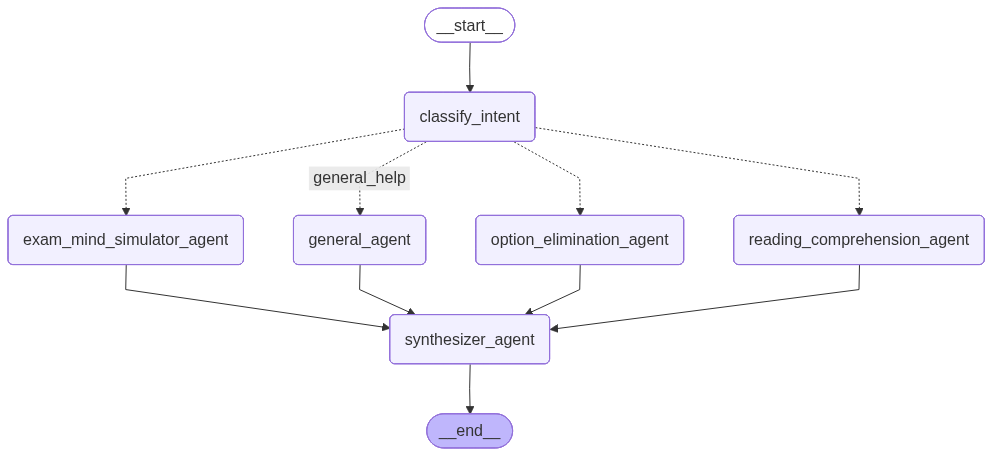

In [13]:
workflow

In [14]:
initial_state = {
    "passage":"""[T]he idea of craftsmanship is not simply nostalgic. . . . Crafts require distinct skills, an all-round approach to work that involves the whole product, rather than individual parts, and an attitude that necessitates devotion to the job and a focus on the communal interest. The concept of craft emphasises the human touch and individual judgment.

    Essentially, the crafts concept seems to run against the preponderant ethos of management studies which, as the academics note, have long prioritised efficiency and consistency. . . . Craft skills were portrayed as being primitive and traditionalist.

    The contrast between artisanship and efficiency first came to the fore in the 19th century when British manufacturers suddenly faced competition from across the Atlantic as firms developed the "American system" using standardised parts. . . . the worldwide success of the Singer sewing machine showed the potential of a mass-produced device. This process created its own reaction, first in the form of the Arts and Crafts movement of the late 19th century, and then again in the "small is beautiful" movement of the 1970s. A third crafts movement is emerging as people become aware of the environmental impact of conventional industry.

    There are two potential markets for those who practise crafts. The first stems from the existence of consumers who are willing to pay a premium price for goods that are deemed to be of extra quality. . . . The second market lies in those consumers who wish to use their purchases to support local workers, or to reduce their environmental impact by taking goods to craftspeople to be mended, or recycled.

    For workers, the appeal of craftsmanship is that it allows them the autonomy to make creative choices, and thus makes a job far more satisfying. In that sense, it could offer hope for the overall labour market. Let the machines automate dull and repetitive tasks and let workers focus purely on their skills, judgment and imagination. As a current example, the academics cite the "agile" manifesto in the software sector, an industry at the heart of technological change. The pioneers behind the original agile manifesto promised to prioritise "individuals and interactions over processes and tools". By bringing together experts from different teams, agile working is designed to improve creativity.

    But the broader question is whether crafts can create a lot more jobs than they do today. Demand for crafted products may rise but will it be easy to retrain workers in sectors that might get automated (such as truck drivers) to take advantage? In a world where products and services often have to pass through regulatory hoops, large companies will usually have the advantage.

    History also suggests that the link between crafts and creativity is not automatic. Medieval craft guilds were monopolies which resisted new entrants. They were also highly hierarchical with young men required to spend long periods as apprentices and journeymen before they could set up on their own; by that time the innovative spirit may have been knocked out of them. Craft workers can thrive in the modern era, but only if they don't get too organised.""",

    "user_query":""" what is the tone of the passage?"""
}

final_state = workflow.invoke(initial_state)
print(final_state['final_answer'])

📋 Classified Intent: reading_comprehension (RC Type: tone)  (difficulty: medium)
🎯 Intent in route based on intent function: reading_comprehension
🎯 Intent: reading_comprehension → Routing to: reading_comprehension_agent
 running the reading comprehnesion agent
intent='reading_comprehension' difficulty_level='medium' rc_question_type='tone'
Running synthesiser agent
 intnet in the synthesiser agent reading_comprehension
**Tone Analysis:**

**Tone:** Cautious

**Explanation:** The passage presents a balanced view of craftsmanship, acknowledging its potential benefits while also highlighting significant challenges and historical limitations. Phrases like 'the broader question is whether crafts can create a lot more jobs than they do today' and 'history also suggests that the link between crafts and creativity is not automatic' indicate a careful consideration of the complexities involved, rather than an outright endorsement of craftsmanship.


In [30]:
initial_state = {
    "passage":"""[T]he idea of craftsmanship is not simply nostalgic. . . . Crafts require distinct skills, an all-round approach to work that involves the whole product, rather than individual parts, and an attitude that necessitates devotion to the job and a focus on the communal interest. The concept of craft emphasises the human touch and individual judgment.

    Essentially, the crafts concept seems to run against the preponderant ethos of management studies which, as the academics note, have long prioritised efficiency and consistency. . . . Craft skills were portrayed as being primitive and traditionalist.

    The contrast between artisanship and efficiency first came to the fore in the 19th century when British manufacturers suddenly faced competition from across the Atlantic as firms developed the "American system" using standardised parts. . . . the worldwide success of the Singer sewing machine showed the potential of a mass-produced device. This process created its own reaction, first in the form of the Arts and Crafts movement of the late 19th century, and then again in the "small is beautiful" movement of the 1970s. A third crafts movement is emerging as people become aware of the environmental impact of conventional industry.

    There are two potential markets for those who practise crafts. The first stems from the existence of consumers who are willing to pay a premium price for goods that are deemed to be of extra quality. . . . The second market lies in those consumers who wish to use their purchases to support local workers, or to reduce their environmental impact by taking goods to craftspeople to be mended, or recycled.

    For workers, the appeal of craftsmanship is that it allows them the autonomy to make creative choices, and thus makes a job far more satisfying. In that sense, it could offer hope for the overall labour market. Let the machines automate dull and repetitive tasks and let workers focus purely on their skills, judgment and imagination. As a current example, the academics cite the "agile" manifesto in the software sector, an industry at the heart of technological change. The pioneers behind the original agile manifesto promised to prioritise "individuals and interactions over processes and tools". By bringing together experts from different teams, agile working is designed to improve creativity.

    But the broader question is whether crafts can create a lot more jobs than they do today. Demand for crafted products may rise but will it be easy to retrain workers in sectors that might get automated (such as truck drivers) to take advantage? In a world where products and services often have to pass through regulatory hoops, large companies will usually have the advantage.

    History also suggests that the link between crafts and creativity is not automatic. Medieval craft guilds were monopolies which resisted new entrants. They were also highly hierarchical with young men required to spend long periods as apprentices and journeymen before they could set up on their own; by that time the innovative spirit may have been knocked out of them. Craft workers can thrive in the modern era, but only if they don't get too organised.""",

    "user_query":"""
    question_text: Which one of the following statements is NOT inconsistent with the views stated in the passage?
options:
A) Creativity in the crafts could be stifled if the market for artisan goods becomes too organised.
B) The Arts and Crafts movement was initially inspired by the "American system" of production.
C) The agile movement in software is a throwback to the tenets of the medieval crafts guilds.
D) We need to support the crafts; only then can we retain the creativity intrinsic to their production.
    """
}

final_state = workflow.invoke(initial_state)


#  How as a student, while reading the passage, I can say that, examiner will create question from this section of the passage, how I can fit in examiner shoe and think like examiner to answer correct question.
#     How I can develop thinking like that, like I read the passage and be sure that question will come from this section of the passage.
#     Suppose you are examiner, how would you solve this question?
#     how to solve this question based on the passage, give me step by step . Give me correct answer and explanation.



# what is the correct answer and how to solve this question based on the passage, give me step by step and how to eliminate options . Give me correct answer and explanation.

📋 Classified Intent: reading_comprehension (RC Type: detail)  (difficulty: medium)
🎯 Intent in route based on intent function: reading_comprehension
🎯 Intent: reading_comprehension → Routing to: reading_comprehension_agent
 running the reading comprehnesion agent
intent='reading_comprehension' difficulty_level='medium' rc_question_type='detail'
Running synthesiser agent
 intnet in the synthesiser agent reading_comprehension


In [31]:
final_state['final_answer'] 

'To determine which statement is NOT inconsistent with the views stated in the passage, we need to analyze each option in the context of the passage.\n\nA) Creativity in the crafts could be stifled if the market for artisan goods becomes too organised.\n- The passage mentions that craft workers can thrive in the modern era, but only if they don\'t get too organized. This suggests that excessive organization could stifle creativity, making this statement consistent with the passage.\n\nB) The Arts and Crafts movement was initially inspired by the "American system" of production.\n- The passage states that the Arts and Crafts movement was a reaction to the "American system" of production, not inspired by it. Therefore, this statement is inconsistent with the passage.\n\nC) The agile movement in software is a throwback to the tenets of the medieval crafts guilds.\n- The passage contrasts the agile movement with the medieval crafts guilds, noting that the latter were monopolistic and hiera

In [18]:
initial_state = {
    "passage":"""[T]he idea of craftsmanship is not simply nostalgic. . . . Crafts require distinct skills, an all-round approach to work that involves the whole product, rather than individual parts, and an attitude that necessitates devotion to the job and a focus on the communal interest. The concept of craft emphasises the human touch and individual judgment.

    Essentially, the crafts concept seems to run against the preponderant ethos of management studies which, as the academics note, have long prioritised efficiency and consistency. . . . Craft skills were portrayed as being primitive and traditionalist.

    The contrast between artisanship and efficiency first came to the fore in the 19th century when British manufacturers suddenly faced competition from across the Atlantic as firms developed the "American system" using standardised parts. . . . the worldwide success of the Singer sewing machine showed the potential of a mass-produced device. This process created its own reaction, first in the form of the Arts and Crafts movement of the late 19th century, and then again in the "small is beautiful" movement of the 1970s. A third crafts movement is emerging as people become aware of the environmental impact of conventional industry.

    There are two potential markets for those who practise crafts. The first stems from the existence of consumers who are willing to pay a premium price for goods that are deemed to be of extra quality. . . . The second market lies in those consumers who wish to use their purchases to support local workers, or to reduce their environmental impact by taking goods to craftspeople to be mended, or recycled.

    For workers, the appeal of craftsmanship is that it allows them the autonomy to make creative choices, and thus makes a job far more satisfying. In that sense, it could offer hope for the overall labour market. Let the machines automate dull and repetitive tasks and let workers focus purely on their skills, judgment and imagination. As a current example, the academics cite the "agile" manifesto in the software sector, an industry at the heart of technological change. The pioneers behind the original agile manifesto promised to prioritise "individuals and interactions over processes and tools". By bringing together experts from different teams, agile working is designed to improve creativity.

    But the broader question is whether crafts can create a lot more jobs than they do today. Demand for crafted products may rise but will it be easy to retrain workers in sectors that might get automated (such as truck drivers) to take advantage? In a world where products and services often have to pass through regulatory hoops, large companies will usually have the advantage.

    History also suggests that the link between crafts and creativity is not automatic. Medieval craft guilds were monopolies which resisted new entrants. They were also highly hierarchical with young men required to spend long periods as apprentices and journeymen before they could set up on their own; by that time the innovative spirit may have been knocked out of them. Craft workers can thrive in the modern era, but only if they don't get too organised.""",

    "user_query":"""
    question_text: Which of the following statements, if false, would be inconsistent with the concerns raised in the passage regarding the drivers of carnivore-human conflicts?
    options:
    A) Climate change has had negligible effects on the frequency of carnivore-human interactions in affected regions.
    B) Carnivores lose their instinctive fear of humans when consistently exposed to human food sources.
    C) Predatory attacks by carnivores are a common occurrence and have steadily increased over the past few decades.
    D) Human efforts to avoid risky behaviors around large carnivores have proven effective in reducing conflict incidents..

    give me step by step and how to eliminate options . Give me correct answer and explanation.
    """
}

final_state = workflow.invoke(initial_state)


#  How as a student, while reading the passage, I can say that, examiner will create question from this section of the passage, how I can fit in examiner shoe and think like examiner to answer correct question.
#     How I can develop thinking like that, like I read the passage and be sure that question will come from this section of the passage.
#     Suppose you are examiner, how would you solve this question?
#     how to solve this question based on the passage, give me step by step . Give me correct answer and explanation.



# what is the correct answer and how to solve this question based on the passage, give me step by step and how to eliminate options . Give me correct answer and explanation.

📋 Classified Intent: critical_reasoning (RC Type: None)  (difficulty: hard)
🎯 Intent in route based on intent function: critical_reasoning
🎯 Intent: critical_reasoning → Routing to: general_help
 running the general agent
Running synthesiser agent
 intnet in the synthesiser agent critical_reasoning


UnboundLocalError: cannot access local variable 'final_response' where it is not associated with a value

In [ ]:
final_state['final_answer'] 

'To determine which scenario would most likely exacerbate the frequency of carnivore-human conflicts, we will systematically analyze each option based on the criteria provided.\n\n### SYSTEMATIC LOGICAL ELIMINATION\n\n1. **Option A: Attempting to photograph wild animals from within secured viewing areas in national parks and protected zones.**\n   - **Logical relationship to passage content:** This option suggests a controlled environment where human interaction with wildlife is limited.\n   - **Scope accuracy:** The scope is too narrow; it does not directly relate to increasing conflicts.\n   - **Factual accuracy vs. passage statements:** The passage does not indicate that photographing animals in secured areas leads to conflicts.\n   - **Logical consistency with question requirements:** This option is unlikely to exacerbate conflicts, as it implies a safe distance from wildlife.\n   - **Elimination:** **Eliminate A.**\n\n2. **Option B: Implementing \'food waste\' management strategie

In [1]:
original_prompt = """
Identify the conclusion, 
Identify an entailment (also known as implication), 
Infer what is most strongly supported, 
Identify or infer an issue in dispute doesn’t 
"""

# Replace commas with apostrophes
cleaned_prompt = original_prompt.replace("’", "'")

print(cleaned_prompt)


Identify the conclusion, 
Identify an entailment (also known as implication), 
Infer what is most strongly supported, 
Identify or infer an issue in dispute doesn't 



In [ ]:
list_of_prompts = [
    "conclusion_agent_prompt",
    "implication_agent_prompt",
    "strongly_supported_agent_prompt",
    "issue_in_dispute_agent_prompt",
    "identify_technique_agent_prompt",
    "identify_role_agent_prompt",
    "identify_principle_agent_prompt",
    "match_structure_agent_prompt",
    "flaw_agent_prompt",
    "match_flaw_agent_prompt",
    "necessary_assumptions_agent_prompt",
    "sufficient_assumptions_agent_prompt",
    "strengthen_agent_prompt",
    "weaken_agent_prompt",
    "helpful_info_agent_prompt",
    "explain_agent_prompt",
    "resolve_conflict_agent_prompt"
]

print(len(list_of_prompts))
# Loop through each variable name
for prompt_name in list_of_prompts:
    # Get the actual object (should be a ChatPromptTemplate)
    prompt_obj = globals()[prompt_name]

    # Replace `’` with `'` in all string messages
    updated_messages = []
    for role, message in prompt_obj.messages:
        if isinstance(message, str):
            message = message.replace("’", "'")  # Replace fancy apostrophe with regular
        updated_messages.append((role, message))
    
    # Update the variable with the cleaned version
    globals()[prompt_name] = ChatPromptTemplate.from_messages(updated_messages)

